# Learning Box Embeddings with Example

This tutorial outlines the different functionalities available within the Box Embeddings package

### 0. Installing the package on your machine

*If you have the repo cloned*
```
pip install --editable . --user
```

### A. Initialize a box tensor and check its parameters

#### Standard Box Tensor
To represent a Tensor as a Box, we use the class `BoxTensor`. The necessary parameter is `data` (a tensor)

In [2]:
from box_embeddings.parameterizations.box_tensor import *
# Let's create a toy example
x_min = [-2.0]*50
x_max = [0.0]*50
data_x = torch.tensor([[[1,2],[-1,5]], [[0,2],[-2,3]], [[-3,3],[-2,4]]])
#tensor = torch.tensor(np.random.rand(3, 2, 2))
box_1 = BoxTensor(data_x)
box_1

BoxTensor(tensor([[[ 1,  2],
         [-1,  5]],

        [[ 0,  2],
         [-2,  3]],

        [[-3,  3],
         [-2,  4]]]))

We can use several methods to look at the parameters of our box, such as

In [3]:
# Lower left coordinate
print(box_1.z)
# Top right coordinate
print(box_1.Z)
# Center coordinate
print(box_1.centre)

tensor([[ 1,  2],
        [ 0,  2],
        [-3,  3]])
tensor([[-1,  5],
        [-2,  3],
        [-2,  4]])
tensor([[ 0.0000,  3.5000],
        [-1.0000,  2.5000],
        [-2.5000,  3.5000]])


Let's broadcast our box to a new shape.. Broadcasting is often needed for different arithmetic operations. The function we
will use is `broadcast()`, and the required parameter is `target_shape=()`, which specify the new shape
for the box. This is very similar to `numpy.broadcast_to()`

In [4]:
data = torch.tensor([[[1, 2, 3], [3, 4, 6]],
          [[5, 6, 8], [7, 9, 5]]])
box = BoxTensor(data)
print('previous shape is:', box.box_shape)
box.broadcast(target_shape=(2, 1, 3))
print('after broadcasting:', box.box_shape)

previous shape is: (2, 3)
after broadcasting: (2, 1, 3)


### 2. Box Volume
To calculate the volume of a box, we can use either the `soft_volume`, or the Bessel volume via `bessel_volume_approx`.
To ensure numerical stability, we can use the log version via `log_soft_volume` or `log_bessel_volume_approx`

In [34]:
from box_embeddings.modules.volume.soft_volume import soft_volume

# Create data as tensors, and initialize a box
data = torch.tensor([[-2.0]*100, [0.0]*100])
box_1 = BoxTensor(data)

# Logged Soft volume
print(soft_volume(box_1))

#Soft volume
print(soft_volume(box_1, log_scale=False))

tensor(75.4679)
tensor(5.9605e+32)


### 3. Box Intersection

To calculate the intersection of two boxes (which yields a box), we can use either `hard_intersection` or
`gumbel_intersection`

In [35]:
from box_embeddings.modules.intersection import hard_intersection, gumbel_intersection

# Create data as tensors, and initialize two boxes, box_1 and box_2
x_min = [-2.0]*100
x_max = [0.0]*100
data_x = torch.tensor([x_min, x_max])
box_1 = BoxTensor(data_x)

y_min = [1/n for n in range(1, 101)]
y_max = [1 - k for k in reversed(y_min)]
data_y = torch.tensor([y_min, y_max], requires_grad=True)
box_2 = BoxTensor(data_y)

# Intersection of box_1 and box_2
print(hard_intersection(box_1, box_2))

# Gumbel intersection of box_1 and box_2
print(gumbel_intersection(box_1, box_2))

BoxTensor(z=tensor([1.0000, 0.5000, 0.3333, 0.2500, 0.2000, 0.1667, 0.1429, 0.1250, 0.1111,
        0.1000, 0.0909, 0.0833, 0.0769, 0.0714, 0.0667, 0.0625, 0.0588, 0.0556,
        0.0526, 0.0500, 0.0476, 0.0455, 0.0435, 0.0417, 0.0400, 0.0385, 0.0370,
        0.0357, 0.0345, 0.0333, 0.0323, 0.0312, 0.0303, 0.0294, 0.0286, 0.0278,
        0.0270, 0.0263, 0.0256, 0.0250, 0.0244, 0.0238, 0.0233, 0.0227, 0.0222,
        0.0217, 0.0213, 0.0208, 0.0204, 0.0200, 0.0196, 0.0192, 0.0189, 0.0185,
        0.0182, 0.0179, 0.0175, 0.0172, 0.0169, 0.0167, 0.0164, 0.0161, 0.0159,
        0.0156, 0.0154, 0.0152, 0.0149, 0.0147, 0.0145, 0.0143, 0.0141, 0.0139,
        0.0137, 0.0135, 0.0133, 0.0132, 0.0130, 0.0128, 0.0127, 0.0125, 0.0123,
        0.0122, 0.0120, 0.0119, 0.0118, 0.0116, 0.0115, 0.0114, 0.0112, 0.0111,
        0.0110, 0.0109, 0.0108, 0.0106, 0.0105, 0.0104, 0.0103, 0.0102, 0.0101,
        0.0100], grad_fn=<MaximumBackward>),
Z=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

### 4. Box Training
In the following example, we train a simple box `box_2` to require it to be completely contained inside another box
`box_1`. The training loop returns the best `box_1` and `box_2`.

In [9]:
# Initialize and Training
import numpy
from box_embeddings.parameterizations.box_tensor import BoxTensor
from box_embeddings.modules.volume.volume import Volume
from box_embeddings.modules.intersection import Intersection

x_z = numpy.array([-2.0 for n in range(1, 16)])
x_Z = numpy.array([0.0 for k in (x_z)])
data_x = torch.tensor([x_z, x_Z], requires_grad=True)
box_1 = BoxTensor(data_x)

y_z = numpy.array([1/n for n in range(1, 16)])
y_Z = numpy.array([1 + k for k in reversed(y_z)])
data_y = torch.tensor([y_z, y_Z], requires_grad=True)
box_2 = BoxTensor(data_y)

# Training loop
learning_rate = 0.1
def train(box_1, box_2, optimizer, epochs=1):
    best_loss = int()
    best_box_1 = None
    best_box_2 = None
    box_vol = Volume(volume_temperature=0.1, intersection_temperature=0.0001)
    box_int = Intersection(intersection_temperature=0.0001)
    for e in range(epochs):
        loss = box_vol(box_2) - box_vol(box_int(box_1, box_2))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if best_loss < loss.item():
            best_loss = loss.item()
            best_box_2 = box_2
            best_box_1 = box_1
        print('Iteration %d, loss = %.4f' % (e, loss.item()))
    return best_box_1, best_box_2

optimizer =  torch.optim.SGD([data_x, data_y], lr=learning_rate)
contained_box1, contained_box2 = train(box_1, box_2, optimizer, epochs=20)
# Print the coordinates of the boxes after training
print(contained_box1)
print(contained_box2)

Iteration 0, loss = 67.5864
Iteration 1, loss = 1.9609
Iteration 2, loss = 1.2382
Iteration 3, loss = 0.8086
Iteration 4, loss = 0.5695
Iteration 5, loss = 0.4213
Iteration 6, loss = 0.3193
Iteration 7, loss = 0.2446
Iteration 8, loss = 0.2030
Iteration 9, loss = 0.1628
Iteration 10, loss = 0.1237
Iteration 11, loss = 0.0855
Iteration 12, loss = 0.0478
Iteration 13, loss = 0.0105
Iteration 14, loss = 0.0000
Iteration 15, loss = 0.0000
Iteration 16, loss = 0.0000
Iteration 17, loss = 0.0000
Iteration 18, loss = 0.0000
Iteration 19, loss = 0.0000
BoxTensor(tensor([[-2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000,
         -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000, -2.0000],
        [ 1.0000,  0.9967,  0.9827,  1.0260,  1.0031,  0.9823,  0.9643,  1.0109,
          0.9980,  0.9869,  1.0375,  1.0291,  1.0792,  1.1801,  1.4934]],
       dtype=torch.float64, requires_grad=True))
BoxTensor(tensor([[ 0.6114, -0.3223, -0.5149, -0.5917, -0.6285, -0.6475, -0.6580,

Visualization of the boxes before and after training

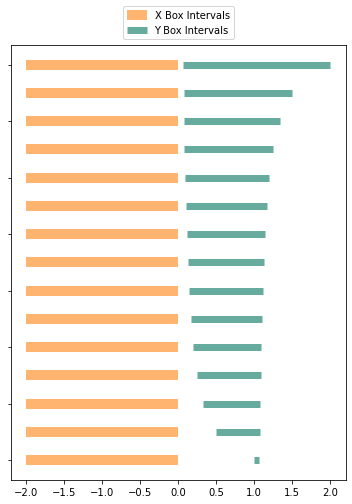

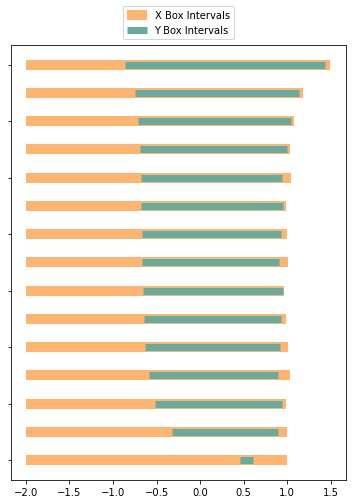

In [10]:
from typing import List
from matplotlib import pyplot as plt
import matplotlib
# Visualization functions
def plot_dimension_interval(ax, cmap, dim_: int, x_box: List[float], y_box: List[float], x_color='#FFB570', y_color='#67AB9F',
                            label=False):
    if not label:
        ax.hlines(dim_, x_box[0], x_box[1], x_color, lw=10)
        ax.hlines(dim_, y_box[0], y_box[1], y_color, lw=7)
    else:
        ax.hlines(dim_, x_box[0], x_box[1], x_color, lw=10, label='X Box Intervals', cmap=cmap)
        ax.hlines(dim_, y_box[0], y_box[1], y_color, lw=7, label='Y Box Intervals', cmap=cmap)

def plot_x_and_y_box(axs, cmap, x_z, x_Z, y_z, y_Z):
    for dim_ in range(y_z.shape[0]):
        p = dim_ % axs.shape[0]
        plot_dimension_interval(axs[p][0], cmap, dim_, [x_z[dim_], x_Z[dim_]], [y_z[dim_], y_Z[dim_]], label=(dim_==0))
    for i in range(axs.shape[0]):
        axs[i][0].yaxis.set_ticklabels([])
    axs[0][0].legend(bbox_to_anchor=(0.5, 1.1), loc="upper center")

# Plot the coordinates of the boxes before training
fig, axs = plt.subplots(1, 1, figsize=(6,8))
axs = numpy.array([axs], dtype=object).reshape(1, 1)
cmap = matplotlib.cm.get_cmap('Wistia')
mappable = matplotlib.cm.ScalarMappable(cmap=cmap)
plot_x_and_y_box(axs, cmap, x_z, x_Z, y_z, y_Z)
plt.show()

# Plot the coordinates of the boxes after training
fig, axs = plt.subplots(1, 1, figsize=(6,8))
axs = numpy.array([axs], dtype=object).reshape(1, 1)
plot_x_and_y_box(axs, cmap, contained_box1.z.detach().numpy(), contained_box1.Z.detach().numpy(),
                 contained_box2.z.detach().numpy(), contained_box2.Z.detach().numpy())
plt.show()
